Data analysis for Zhang and Petersen et al 2019

# Data & preprocessing

## Imports

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.interpolate import UnivariateSpline
from scipy import stats
import pickle
import utility_ZP as utils_p

# Import ART
sys.path.append('./AutomatedRecommendationTool')

from art.core import *
import art.plot as plot

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
sns.set_context("talk")
sns.set_style("white")

## Import data and reformat

### from ICE 

In [3]:
#import requests

#ICE_user = "XXXX"
#ICE_pass = "YYYY"

#headers = {'Content-Type': 'application/json'}
#data = f'{{email:{ICE_user}, password:{ICE_pass}}}'
#sessionId = requests.post('https://public-registry.jbei.org/rest/accesstokens', headers=headers, data=data).json()['sessionId']

#headers = {'Content-Type': 'application/json','X-ICE-Authentication-SessionId': sessionId,'Cache-Control': 'no-cache'}
#parts_list = [requests.get('https://public-registry.jbei.org/rest/parts/' + str(query), headers=headers).json() for query in range(12607,13183)]

#ice = pd.DataFrame(parts_list, columns = ['name','shortDescription','alias','strainData'])
#ice['strainData'] = [dictionary['genotypePhenotype'] for dictionary in ice.strainData]
#ice.to_csv('./ice.csv',index=False)

In [3]:
ice = pd.read_csv('ice.csv')
ice.head()

,name,shortDescription,alias,strainData
0,SP001,Cured: y; Single_population: y,yp23_A01,04_08_17_20_NI
1,SP002,Cured: y; Single_population: y,yp23_A02,04_NI_13_19_26
2,SP003,Cured: y; Single_population: y,yp23_A03,02_11_13_24_29
3,SP004,Cured: y; Single_population: y,yp23_A04,02_11_13_19_25
4,SP005,Cured: y; Single_population: y,yp23_A05,05_07_16_22_NI


Is there one line for each strain? (96 wells_p_plate * 6 plates = 576 wells)

In [4]:
assert len(ice) == 576

Split information in 'shortDescription' into seperate columns

In [5]:
ice['cured'], ice['single_population'] = ice['shortDescription'].str.split(';', 1).str
ice['cured'] = [ele.split(": ", 1)[1].replace("'","") for ele in ice.cured]
ice['single_population'] = [ele.split(": ", 1)[1] for ele in ice.single_population]
ice.head()

,name,shortDescription,alias,strainData,cured,single_population
0,SP001,Cured: y; Single_population: y,yp23_A01,04_08_17_20_NI,y,y
1,SP002,Cured: y; Single_population: y,yp23_A02,04_NI_13_19_26,y,y
2,SP003,Cured: y; Single_population: y,yp23_A03,02_11_13_24_29,y,y
3,SP004,Cured: y; Single_population: y,yp23_A04,02_11_13_19_25,y,y
4,SP005,Cured: y; Single_population: y,yp23_A05,05_07_16_22_NI,y,y


Split information in 'alias' into seperate columns

In [6]:
ice['plate'], ice['well'] = ice['alias'].str.split('_', 1).str
ice['row'] = ice['well'].str[0]
ice['col'] = ice['well'].str[1:3]
ice.head()

,name,shortDescription,alias,strainData,cured,single_population,plate,well,row,col
0,SP001,Cured: y; Single_population: y,yp23_A01,04_08_17_20_NI,y,y,yp23,A01,A,01
1,SP002,Cured: y; Single_population: y,yp23_A02,04_NI_13_19_26,y,y,yp23,A02,A,02
2,SP003,Cured: y; Single_population: y,yp23_A03,02_11_13_24_29,y,y,yp23,A03,A,03
3,SP004,Cured: y; Single_population: y,yp23_A04,02_11_13_19_25,y,y,yp23,A04,A,04
4,SP005,Cured: y; Single_population: y,yp23_A05,05_07_16_22_NI,y,y,yp23,A05,A,05


Rename columns according to EDD

In [7]:
ice = ice.drop(columns = ['shortDescription', 'alias'])

In [8]:
ice.columns = ['Line Name','Line Description', 'cured', 'single_population','plate','well','row','col']
ice.head()

,Line Name,Line Description,cured,single_population,plate,well,row,col
0,SP001,04_08_17_20_NI,y,y,yp23,A01,A,01
1,SP002,04_NI_13_19_26,y,y,yp23,A02,A,02
2,SP003,02_11_13_24_29,y,y,yp23,A03,A,03
3,SP004,02_11_13_19_25,y,y,yp23,A04,A,04
4,SP005,05_07_16_22_NI,y,y,yp23,A05,A,05


### from EDD

In [9]:
#edd_study_slug = 'petersen-et-al-2019'
#edd_server = 'edd-test.jbei.org'
#edd = utils.load_EDD_study(edd_study_slug=edd_study_slug, edd_server=edd_server)
#edd.to_csv('./edd.csv',index=False)

In [10]:
edd = pd.read_csv('edd.csv',usecols = ['Line Name', 'Line Description', 'Measurement Type', 'Value', 'Hours'])
edd.head()

,Line Name,Line Description,Measurement Type,Value,Hours
0,SP001-r1,Background: n,Optical Density,0.117,13.0
1,SP001-r1,Background: n,Optical Density,0.116,28.0
2,SP001-r1,Background: n,Optical Density,0.116,43.0
3,SP001-r1,Background: n,Optical Density,0.116,58.0
4,SP001-r1,Background: n,Optical Density,0.116,73.0


Did all OD and gfp measurements get imported? (2 x 144576 = 289152 lines)

In [11]:
assert len(edd) == 289152

remove 'Background: ' from column Line_description

In [12]:
edd['Line Description'] = [x[12:] for x in edd['Line Description']]
edd.head()

,Line Name,Line Description,Measurement Type,Value,Hours
0,SP001-r1,n,Optical Density,0.117,13.0
1,SP001-r1,n,Optical Density,0.116,28.0
2,SP001-r1,n,Optical Density,0.116,43.0
3,SP001-r1,n,Optical Density,0.116,58.0
4,SP001-r1,n,Optical Density,0.116,73.0


What measurement types did we import?

In [13]:
edd['Measurement Type'].value_counts()

Enhanced Green Fluorescent Protein    144576
Optical Density                       144576
Name: Measurement Type, dtype: int64

Move measurements of 'Optical Density' and 'Enhanced Green Fluorescent Protein' into seperate columns

In [14]:
edd = edd.set_index(['Line Name','Line Description', 'Hours', 'Measurement Type'])
edd = edd.unstack().reset_index()
edd.head()

Line Name Line Description Hours  \
Measurement Type                                    
0                 SP001-r1                n  13.0   
1                 SP001-r1                n  28.0   
2                 SP001-r1                n  43.0   
3                 SP001-r1                n  58.0   
4                 SP001-r1                n  73.0   

                                              Value                  
Measurement Type Enhanced Green Fluorescent Protein Optical Density  
0                                             502.0           0.117  
1                                             509.0           0.116  
2                                             464.0           0.116  
3                                             476.0           0.116  
4                                             461.0           0.116

Collapse multiindex of columns

In [15]:
edd.columns = edd.columns.droplevel()
edd.columns = ['Line Name', 'used_for_bg_subtraction', 'time', 'gfp', 'od']
edd.head()

,Line Name,used_for_bg_subtraction,time,gfp,od
0,SP001-r1,n,13.0,502.0,0.117
1,SP001-r1,n,28.0,509.0,0.116
2,SP001-r1,n,43.0,464.0,0.116
3,SP001-r1,n,58.0,476.0,0.116
4,SP001-r1,n,73.0,461.0,0.116


Split information in 'Line Name' into seperate columns

In [16]:
edd['Line Name'], edd['replicate_count'] = edd['Line Name'].str.split('-', 1).str
edd.head()

,Line Name,used_for_bg_subtraction,time,gfp,od,replicate_count
0,SP001,n,13.0,502.0,0.117,r1
1,SP001,n,28.0,509.0,0.116,r1
2,SP001,n,43.0,464.0,0.116,r1
3,SP001,n,58.0,476.0,0.116,r1
4,SP001,n,73.0,461.0,0.116,r1


### Merge edd and ice

In [17]:
strains_unnested = pd.merge(ice, edd, on = 'Line Name')
strains_unnested.head()

,Line Name,Line Description,cured,single_population,plate,well,row,col,used_for_bg_subtraction,time,gfp,od,replicate_count
0,SP001,04_08_17_20_NI,y,y,yp23,A01,A,01,n,13.0,502.0,0.117,r1
1,SP001,04_08_17_20_NI,y,y,yp23,A01,A,01,n,28.0,509.0,0.116,r1
2,SP001,04_08_17_20_NI,y,y,yp23,A01,A,01,n,43.0,464.0,0.116,r1
3,SP001,04_08_17_20_NI,y,y,yp23,A01,A,01,n,58.0,476.0,0.116,r1
4,SP001,04_08_17_20_NI,y,y,yp23,A01,A,01,n,73.0,461.0,0.116,r1


Merge lib and rec strains. This will not be necassary when recommendations are on ICE and EDD

In [18]:
recommendations = pd.read_csv('recommendations.csv', dtype={'col': object,'time': float,'gfp': float})
recommendations.head()

,Line Name,Line Description,cured,single_population,plate,well,row,col,used_for_bg_subtraction,time,gfp,od,replicate_count
0,SP590,02_08_16_20_29,y,y,yp36,A01,A,01,n,13.0,384.0,0.1402,r1
1,SP590,02_08_16_20_29,y,y,yp36,A01,A,01,n,28.0,341.0,0.1397,r1
2,SP590,02_08_16_20_29,y,y,yp36,A01,A,01,n,43.0,392.0,0.1369,r1
3,SP590,02_08_16_20_29,y,y,yp36,A01,A,01,n,58.0,319.0,0.1368,r1
4,SP590,02_08_16_20_29,y,y,yp36,A01,A,01,n,95.0,290.0,0.1354,r1


In [19]:
strains_unnested.shape

(144576, 13)

In [20]:
recommendations.shape

(16800, 13)

In [21]:
strains_unnested = pd.concat([strains_unnested, recommendations],ignore_index=True)

In [22]:
strains_unnested.head()

,Line Name,Line Description,cured,single_population,plate,well,row,col,used_for_bg_subtraction,time,gfp,od,replicate_count
0,SP001,04_08_17_20_NI,y,y,yp23,A01,A,01,n,13.0,502.0,0.117,r1
1,SP001,04_08_17_20_NI,y,y,yp23,A01,A,01,n,28.0,509.0,0.116,r1
2,SP001,04_08_17_20_NI,y,y,yp23,A01,A,01,n,43.0,464.0,0.116,r1
3,SP001,04_08_17_20_NI,y,y,yp23,A01,A,01,n,58.0,476.0,0.116,r1
4,SP001,04_08_17_20_NI,y,y,yp23,A01,A,01,n,73.0,461.0,0.116,r1


Keep track of strain origin

In [23]:
strains_unnested['origin'] = np.where(strains_unnested['plate'] == "yp29",'ctr','lib')

In [24]:
recommendation_line_names = pd.Series(recommendations['Line Name'].unique())

In [25]:
rec_lookup = pd.read_csv('./rec_lookup.csv')
rec_lookup = rec_lookup[rec_lookup['Line Name'].isin(recommendations['Line Name'].unique())].reset_index()
JBEI_line_names = rec_lookup[rec_lookup['From'] == 'JBEI']['Line Name']
Tes_line_names  = rec_lookup[rec_lookup['From'] == 'Tes']['Line Name']
both_line_names = rec_lookup[rec_lookup['From'] == 'both']['Line Name']
media_line_names = recommendation_line_names[~recommendation_line_names.isin(rec_lookup['Line Name'])]

In [26]:
strains_unnested.loc[strains_unnested['Line Name'].isin(JBEI_line_names), ['origin']] = 'JBEI'
strains_unnested.loc[strains_unnested['Line Name'].isin(Tes_line_names), ['origin']] = 'Tes'
strains_unnested.loc[strains_unnested['Line Name'].isin(both_line_names), ['origin']] = 'both'
strains_unnested.loc[strains_unnested['Line Name'].isin(media_line_names), ['origin']] = 'media'

In [27]:
strains_unnested['origin'].value_counts()

lib      119904
ctr       24672
JBEI       7972
Tes        5895
media      2366
both        567
Name: origin, dtype: int64

In [28]:
strains_unnested[['Line Name','origin']].groupby(['Line Name']).first()['origin'].value_counts()

lib      480
ctr       96
JBEI      22
Tes       17
media      7
both       2
Name: origin, dtype: int64

## Transform data

Change time values from minutes to hours. This is for convenience when plotting and when calculating growth rates

In [29]:
strains_unnested['time'] = strains_unnested.time / 60

### Subtract background od and gfp by plate

Here a small error is made when subtracting background od and gfp for the library strains. The error however is insignificant as we use relative and not absolute od and gfp values when calculating titers and rates (see extraction of titer and rates section). We have not corrected this error for the purpose of exactly replicating the modeling results including recommendations.

In [30]:
strains_unnested_lib = strains_unnested.loc[np.logical_or(strains_unnested['origin'] == 'lib',
                                                          strains_unnested['origin'] == 'ctr')]
strains_unnested_rec = strains_unnested.loc[~np.logical_or(strains_unnested['origin'] == 'lib',
                                                          strains_unnested['origin'] == 'ctr')]

In [31]:
strains_unnested_lib.shape

(144576, 14)

In [32]:
strains_unnested_rec.shape

(16800, 14)

Library strains

In [33]:
strains_unnested_lib['od_minus_bg'] = (strains_unnested_lib
                                   .groupby(['plate','replicate_count'], group_keys=False)
                                   .apply(lambda g: g.od - g.od[g.used_for_bg_subtraction == "y"]
                                   .mean()))

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
strains_unnested_lib['gfp_minus_bg'] = (strains_unnested_lib
                                   .groupby(['plate','replicate_count'], group_keys=False)
                                   .apply(lambda g: g.gfp - g.gfp[g.used_for_bg_subtraction == "y"]
                                   .mean()))

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Recommended strains

In [35]:
bg_levels = strains_unnested_rec[strains_unnested_rec['used_for_bg_subtraction'] == "y"].groupby(['plate'], group_keys=False)['gfp','od'].agg(['mean'])
bg_levels.columns = [' '.join(col).strip() for col in bg_levels.columns.values]
bg_levels

,gfp mean,od mean
plate,,
yp36,168.389362,0.089460
yp40,184.855967,0.088069


In [36]:
strains_unnested_rec = pd.merge(strains_unnested_rec, bg_levels,  how='left', left_on=['plate'], right_on = ['plate'])


In [37]:
strains_unnested_rec['od_minus_bg']  = strains_unnested_rec['od']  - strains_unnested_rec['od mean']
strains_unnested_rec['gfp_minus_bg'] = strains_unnested_rec['gfp'] - strains_unnested_rec['gfp mean']

In [38]:
strains_unnested_rec = strains_unnested_rec.drop(columns = ['od mean', 'gfp mean'])

In [39]:
strains_unnested = pd.concat([strains_unnested_lib, strains_unnested_rec],ignore_index=True)

In [40]:
strains_unnested = strains_unnested.drop(columns = ['used_for_bg_subtraction'])

In [41]:
strains_unnested.head()

,Line Name,Line Description,cured,single_population,plate,well,row,col,time,gfp,od,replicate_count,origin,od_minus_bg,gfp_minus_bg
0,SP001,04_08_17_20_NI,y,y,yp23,A01,A,01,0.216667,502.0,0.117,r1,lib,0.018667,92.1893
1,SP001,04_08_17_20_NI,y,y,yp23,A01,A,01,0.466667,509.0,0.116,r1,lib,0.017667,99.1893
2,SP001,04_08_17_20_NI,y,y,yp23,A01,A,01,0.716667,464.0,0.116,r1,lib,0.017667,54.1893
3,SP001,04_08_17_20_NI,y,y,yp23,A01,A,01,0.966667,476.0,0.116,r1,lib,0.017667,66.1893
4,SP001,04_08_17_20_NI,y,y,yp23,A01,A,01,1.216667,461.0,0.116,r1,lib,0.017667,51.1893


In [42]:
strains_unnested.shape

(161376, 15)

### Define a growth threshold that strains need to pass

In [43]:
strains_max_od = (strains_unnested
          .groupby(['Line Name','replicate_count'])
          .apply(lambda g: g.od_minus_bg.max()))
growth_threshold = pd.Series(np.where(strains_max_od > 0.15,"y","n"))

In [44]:
growth_threshold.value_counts()

y    1538
n     378
dtype: int64

### Nest time series data

Place the time series data corresponding to each well into a dataframe and place those dataframes in a column called `time_series`.

Group all data related to each strain.

In [45]:
strains_grouped = strains_unnested.groupby(['Line Name','plate','row','col','well','replicate_count','Line Description','cured', 'single_population','origin'])
strains_grouped = list(strains_grouped)
type(strains_grouped[0])

tuple

In [46]:
strains_grouped[0][0]

('SP001', 'yp23', 'A', '01', 'A01', 'r1', '04_08_17_20_NI', 'y', 'y', 'lib')

In [47]:
strains_grouped[0][1].head()

,Line Name,Line Description,cured,single_population,plate,well,row,col,time,gfp,od,replicate_count,origin,od_minus_bg,gfp_minus_bg
0,SP001,04_08_17_20_NI,y,y,yp23,A01,A,01,0.216667,502.0,0.117,r1,lib,0.018667,92.1893
1,SP001,04_08_17_20_NI,y,y,yp23,A01,A,01,0.466667,509.0,0.116,r1,lib,0.017667,99.1893
2,SP001,04_08_17_20_NI,y,y,yp23,A01,A,01,0.716667,464.0,0.116,r1,lib,0.017667,54.1893
3,SP001,04_08_17_20_NI,y,y,yp23,A01,A,01,0.966667,476.0,0.116,r1,lib,0.017667,66.1893
4,SP001,04_08_17_20_NI,y,y,yp23,A01,A,01,1.216667,461.0,0.116,r1,lib,0.017667,51.1893


Loop over list of tuples and make each tuple one row in the dataframe `strains`

In [48]:
strains = pd.DataFrame(columns=['Line Name','plate','row','col','well','replicate_count','Line Description','cured', 'single_population','origin','time_series'])

for i in range(len(strains_grouped)):
    (strains.at[i,'Line Name'],
    strains.at[i,'plate'],
    strains.at[i,'row'],
    strains.at[i,'col'],
    strains.at[i,'well'],
    strains.at[i,'replicate_count'],
    strains.at[i,'Line Description'],
    strains.at[i,'cured'],
    strains.at[i,'single_population'],
    strains.at[i,'origin']) = strains_grouped[i][0]
    strains.at[i,'time_series'] = (strains_grouped[i][1].drop(columns = ['Line Name','plate','row','col','well','replicate_count','Line Description','cured', 'single_population','origin']).reset_index(drop = True))
strains.head()

,Line Name,plate,row,col,well,replicate_count,Line Description,cured,single_population,origin,time_series
0,SP001,yp23,A,01,A01,r1,04_08_17_20_NI,y,y,lib,time gfp od od_minus_bg gfp...
1,SP001,yp23,A,01,A01,r2,04_08_17_20_NI,y,y,lib,time gfp od od_minus_bg gfp...
2,SP001,yp23,A,01,A01,r3,04_08_17_20_NI,y,y,lib,time gfp od od_minus_bg gf...
3,SP002,yp23,A,02,A02,r1,04_NI_13_19_26,y,y,lib,time gfp od od_minus_bg gfp...
4,SP002,yp23,A,02,A02,r2,04_NI_13_19_26,y,y,lib,time gfp od od_minus_bg gfp...


In [49]:
strains.shape

(1920, 11)

In [50]:
strains.origin.value_counts()

lib      1440
ctr       288
JBEI       92
Tes        67
media      26
both        7
Name: origin, dtype: int64

And the `time_series` column contains `pd.DataFrames` with time series information

In [51]:
strains.time_series.values[0].head()

,time,gfp,od,od_minus_bg,gfp_minus_bg
0,0.216667,502.0,0.117,0.018667,92.1893
1,0.466667,509.0,0.116,0.017667,99.1893
2,0.716667,464.0,0.116,0.017667,54.1893
3,0.966667,476.0,0.116,0.017667,66.1893
4,1.216667,461.0,0.116,0.017667,51.1893


Append the `growth_threshold` information

In [52]:
strains['growth_threshold'] = growth_threshold
strains.head()

,Line Name,plate,row,col,well,replicate_count,Line Description,cured,single_population,origin,time_series,growth_threshold
0,SP001,yp23,A,01,A01,r1,04_08_17_20_NI,y,y,lib,time gfp od od_minus_bg gfp...,y
1,SP001,yp23,A,01,A01,r2,04_08_17_20_NI,y,y,lib,time gfp od od_minus_bg gfp...,y
2,SP001,yp23,A,01,A01,r3,04_08_17_20_NI,y,y,lib,time gfp od od_minus_bg gf...,y
3,SP002,yp23,A,02,A02,r1,04_NI_13_19_26,y,y,lib,time gfp od od_minus_bg gfp...,y
4,SP002,yp23,A,02,A02,r2,04_NI_13_19_26,y,y,lib,time gfp od od_minus_bg gfp...,y


In [53]:
strains.shape

(1920, 12)

Split information in 'Line Description' into seperate columns

In [54]:
strains['p1'],strains['p2'],strains['p3'],strains['p4'],strains['p5'] = strains['Line Description'].str.split('_').str

Change all values into numeric and `NI` or `FA` to `NaN`

In [55]:
strains[['p1', 'p2', 'p3', 'p4', 'p5']] = strains[['p1', 'p2', 'p3', 'p4', 'p5']].apply(pd.to_numeric, errors='coerce')
strains[['p1', 'p2', 'p3', 'p4', 'p5']].head()

,p1,p2,p3,p4,p5
0,4.0,8.0,17.0,20.0,NaN
1,4.0,8.0,17.0,20.0,NaN
2,4.0,8.0,17.0,20.0,NaN
3,4.0,NaN,13.0,19.0,26.0
4,4.0,NaN,13.0,19.0,26.0


## Filter data

Filter out strains that were:
1. never inoculated ie. wells in yeast plate 29 (yp29)
2. inoculated with to few cells and or grew to slow
3. the genotype information was incomplete (`NI`)
4. the assembly failed (`FA`)
5. not cured of complementation plasmid
6. not a single_population

In [56]:
strains.shape

(1920, 17)

In [57]:
strains[np.logical_or(strains.origin == 'lib',
                      strains.origin == 'ctr')].shape

(1728, 17)

In [58]:
NI_mask = (~strains['Line Description'].str.contains('NI'))
FA_mask = (~strains['Line Description'].str.contains('FA'))

Define count function

In [59]:
def count_remaining(df):
    lst = list([df['Line Name'],df['Line Name'].unique(),df['Line Description'].unique()])
    counts = [len(x) for x in lst]
    print('Experimental units: {}, Strains {}, Genotypes {}'.format(counts[0],counts[1],counts[2]))

Count lib and ctr strains remaining after filtering. Related to Figure 4A

In [60]:
# 0.
strains1 = strains[np.logical_or(strains.origin == 'lib',
                                  strains.origin == 'ctr')]
count_remaining(strains1)

# 1.
strains2 = (strains1
            .query('not (plate == "yp29" & row.isin(["A", "B"]))')
            .query('not (plate == "yp29" & col.isin(["07", "08","09","10","11","12"]))')
            .query('not (plate == "yp29" & well.isin(["F04", "F05","F06","G03", "H01","H02","H04","H05","H06"]))'))
count_remaining(strains2)

# 2.
strains3 = strains2.query('growth_threshold == "y"')
count_remaining(strains3)

# 3.
strains4 = strains3 .query('@NI_mask')
count_remaining(strains4)

# 4.
strains5 = strains4.query('@FA_mask')
count_remaining(strains5)

# 5.
strains6 = strains5.query('cured == "y"')
count_remaining(strains6)

# 6.
strains7 = strains6.query('single_population == "y" | single_population == "not_tested"') # We assessed that only strains picked from densely populated plates e.g. our library plates were relevant to test for double populations.
count_remaining(strains7)

Experimental units: 1728, Strains 576, Genotypes 457
Experimental units: 1521, Strains 507, Genotypes 455
Experimental units: 1349, Strains 461, Genotypes 434
Experimental units: 1054, Strains 358, Genotypes 335
Experimental units: 858, Strains 288, Genotypes 268
Experimental units: 795, Strains 267, Genotypes 250
Experimental units: 792, Strains 266, Genotypes 250


Perform filtering of all strains

In [61]:
strains = (strains
 # 1.
 .query('not (plate == "yp29" & row.isin(["A", "B"]))')
 .query('not (plate == "yp29" & col.isin(["07", "08","09","10","11","12"]))')
 .query('not (plate == "yp29" & well.isin(["F04", "F05","F06","G03", "H01","H02","H04","H05","H06"]))')
 # 2.
 .query('growth_threshold == "y"')
 # 3.
 .query('@NI_mask')
 # 4.
 .query('@FA_mask')
 # 5.
 .query('cured == "y"')
 # 6.
 .query('single_population == "y" | single_population == "not_tested"') # We assessed that only strains picked from densely populated plates e.g. our library plates were relevant to test for double populations.
 .reset_index(drop = True)
 .drop(columns = ['plate','row','col','well','growth_threshold', 'cured', 'single_population'])       
)

In [62]:
strains.shape

(953, 10)

## Calculation of library validation statistics

Related to Figure 2B. For library strains:
1. What fraction of genotypes are seen more than once?
2. What fraction of strains has been been succesfully sequenced?
3. What fraction of strains has assembled correctly?
4. What fraction of strains has been cured?


In [63]:
lib_strains = strains[strains['origin']=='lib']
lib_strains_vc = lib_strains['Line Description'].value_counts()

no_of_genotypes = len(lib_strains['Line Description'].unique())
no_of_dup_genotypes = len(lib_strains['Line Name'].unique()) - len(lib_strains['Line Description'].unique())
percent_dup_genotypes = round(no_of_dup_genotypes/ no_of_genotypes * 100,1)
print("Fraction of repeated colonies: {} %".format(percent_dup_genotypes))

Fraction of repeated colonies: 3.7 %


In [64]:
no_of_genotypes = len(lib_strains['Line Description'].unique())
no_of_dup_genotypes = len(lib_strains['Line Name'].unique()) - len(lib_strains['Line Description'].unique())
no_of_genotypes, no_of_dup_genotypes, len(lib_strains['Line Name'].unique())

(245, 9, 254)

In [65]:
no_of_growing_strains  = len(strains3['Line Name'].unique())
no_of_complete_inf_strains = len(strains3.query('@NI_mask')['Line Name'].unique())
percent_complete_inf_strains = round(no_of_complete_inf_strains/no_of_growing_strains * 100,1)
print("Fraction of succesfully sequenced: {} %".format(percent_complete_inf_strains))

Fraction of succesfully sequenced: 77.7 %


In [66]:
no_of_growing_strains  = len(strains3['Line Name'].unique())
no_of_correct_assembly = len(strains3.query('@FA_mask')['Line Name'].unique())
percent_cor_assemblies = round(no_of_correct_assembly/no_of_growing_strains * 100,1)
print("Fraction of correct assemblies: {} %".format(percent_cor_assemblies))

Fraction of correct assemblies: 82.4 %


In [67]:
no_of_growing_strains  = len(strains3['Line Name'].unique())
no_of_cured_strains = len(strains3.query('cured == "y"')['Line Name'].unique())
percent_cured_strains = round(no_of_cured_strains/no_of_growing_strains * 100,1)
print("Fraction of cured: {} %".format(percent_cured_strains))

Fraction of cured: 91.8 %


## Extraction of gfp titer and rate

In [68]:
strains['index_gfp_min'] = 0  # [n_df.gfp_minus_bg.idxmin() for n_df in strains.time_series]
strains['index_gfp_max'] = [_.gfp_minus_bg.idxmax() for _ in strains.time_series]

Fit od, gfp, and gfp/od timeseries using splines

In [69]:
splines_results = strains.apply(lambda row: utils_p.splines(row), axis=1)
strains['spl_od']       = [spl_res[0] for spl_res in splines_results]
strains['spl_gfp']      = [spl_res[1] for spl_res in splines_results]
strains['spl_gfp_p_od'] = [spl_res[2] for spl_res in splines_results]
strains['gfp_p_od_ts']  = [spl_res[3] for spl_res in splines_results]

Use splines to find time points corresponding to: 
1. od = 0.075 
2. od = 0.150
3. the rate of gfp is maximum
4. the rate of od is maximum 

In [70]:
find_times_res = strains.apply(lambda row: utils_p.find_times(row), axis=1)
strains['t_od_t1']      = [time_res[0] for time_res in find_times_res]
strains['t_od_t2']      = [time_res[1] for time_res in find_times_res]
strains['t_r_od_max']   = [time_res[3] for time_res in find_times_res]

Calculate predicted od, gfp, and gfp/od values corresponding to the found time points 

In [71]:
strains['od_t_od_t1']      = strains.apply(lambda row: row['spl_od'](row['t_od_t1']), axis=1)
strains['od_t_od_t2']      = strains.apply(lambda row: row['spl_od'](row['t_od_t2']), axis=1)
strains['od_t_r_od_max']   = strains.apply(lambda row: row['spl_od'](row['t_r_od_max']), axis=1)


In [72]:
strains['gfp_t_od_t1']      = strains.apply(lambda row: row['spl_gfp'](row['t_od_t1']), axis=1)
strains['gfp_t_od_t2']      = strains.apply(lambda row: row['spl_gfp'](row['t_od_t2']), axis=1)
strains['gfp_t_r_od_max']   = strains.apply(lambda row: row['spl_gfp'](row['t_r_od_max']), axis=1)


In [73]:
strains['gfp_p_od_t_od_t1']     = strains.apply(lambda row: row['spl_gfp_p_od'](row['t_od_t1']), axis=1)
strains['gfp_p_od_t_od_t2']     = strains.apply(lambda row: row['spl_gfp_p_od'](row['t_od_t2']), axis=1)
strains['gfp_p_od_t_r_od_max']  = strains.apply(lambda row: row['spl_gfp_p_od'](row['t_r_od_max']), axis=1)

Calculate the difference in time, od, and gfp between t1 and t2. The difference in gfp is also called titer

In [74]:
strains['delta_t']         = strains.apply(lambda row: row['t_od_t2']-row['t_od_t1'], axis=1)
strains['delta_od']        = strains.apply(lambda row: row['od_t_od_t2']-row['od_t_od_t1'], axis=1)
strains['delta_gfp']       = strains.apply(lambda row: row['gfp_t_od_t2']-row['gfp_t_od_t1'], axis=1)

Calculate difference in gfp divided by the difference in time. This results is also called productivity

In [75]:
strains['dgfp_dt'] = strains.apply(lambda row: row['delta_gfp']/row['delta_t'], axis=1)

In [76]:
strains.head()

,Line Name,replicate_count,Line Description,origin,time_series,p1,p2,p3,p4,p5,...,gfp_t_od_t1,gfp_t_od_t2,gfp_t_r_od_max,gfp_p_od_t_od_t1,gfp_p_od_t_od_t2,gfp_p_od_t_r_od_max,delta_t,delta_od,delta_gfp,dgfp_dt
0,SP003,r1,02_11_13_24_29,lib,time gfp od od_minus_bg gfp...,2.0,11.0,13.0,24.0,29.0,...,350.31831262294634,719.4361441492541,1311.71591435308,4699.659395980494,4763.715841111394,1429.734827125743,3.72,0.074807,369.117832,99.225224
1,SP003,r2,02_11_13_24_29,lib,time gfp od od_minus_bg gfp...,2.0,11.0,13.0,24.0,29.0,...,378.31283872465747,717.5286327514972,1405.4869644164728,5034.872338696571,4816.526405891368,3016.7901853077365,3.16,0.075211,339.215794,107.346770
2,SP003,r3,02_11_13_24_29,lib,time gfp od od_minus_bg gf...,2.0,11.0,13.0,24.0,29.0,...,579.2522349354045,891.339112293065,1575.123819879755,7741.328071276553,5929.480569764345,2466.220469271193,2.85,0.075353,312.086877,109.504167
3,SP004,r1,02_11_13_19_25,lib,time gfp od od_minus_bg gfp...,2.0,11.0,13.0,19.0,25.0,...,391.401224209395,802.3893985325226,1710.197181761548,5225.70568448656,5313.995119067842,2184.660960653404,2.42,0.074935,410.988174,169.829824
4,SP004,r2,02_11_13_19_25,lib,time gfp od od_minus_bg gfp...,2.0,11.0,13.0,19.0,25.0,...,380.7317725101923,735.1029510228072,1668.7570441848184,5061.435288793469,4936.929300380902,2694.832956446529,2.28,0.075204,354.371179,155.425955


### Plot individual timeseries

Highlighted is times for which od = 0.075, od = 0.150, and the rate of od is maximum

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


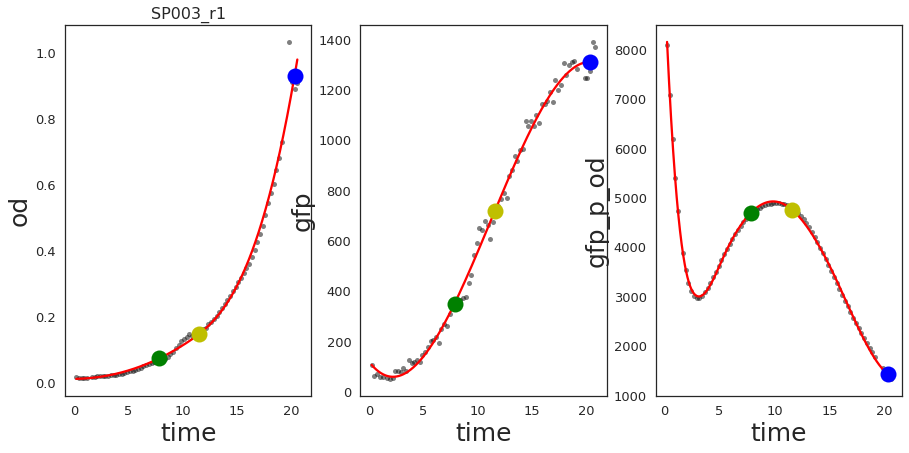

In [77]:
utils_p.plot_strain_by_index(strains, [0])

### Descriptive statistics 

In [78]:
productivity = (strains.groupby(['Line Name', 'origin'])
                       .agg({'dgfp_dt': ['mean', 'sem']})
                       .loc[:,'dgfp_dt']
                       .sort_values(by=['mean'])
                       .reset_index(level='origin'))
productivity.head()

,origin,mean,sem
Line Name,,,
SP245,lib,43.726855,4.925119
SP451,lib,55.253202,1.933611
SP367,lib,60.749836,3.995229
SP364,lib,63.328597,7.110656
SP554,ctr,64.431587,6.487192


**For library strains**

In [85]:
max_lib = productivity[productivity['origin']=='lib']['mean'].max()
print('The maximum productivity is: {}'.format(round(max_lib)))

The maximum productivity is: 256.0


In [86]:
min_lib = productivity[productivity['origin']=='lib']['mean'].min()
print('The minimum productivity is: {}'.format(round(min_lib)))

The minimum productivity is: 44.0


In [87]:
mean_lib = productivity[productivity['origin']=='lib']['mean'].mean()
print('The mean productivity is: {}'.format(round(mean_lib)))

The mean productivity is: 156.0


In [88]:
platform = productivity['mean']['SP507']
print('The mean productivity of the platform strain is: {}'.format(round(platform,1)))

The mean productivity of the platform strain is: 144.8


In [89]:
print('The fold change difference between min and max productivity i.e. design having 5 native promoters is: {}'.format(round(max_lib / min_lib,1)))

The fold change difference between min and max productivity i.e. design having 5 native promoters is: 5.8


In [90]:
sem_mean = productivity[productivity['origin']=='lib']['sem'].mean()
print('The mean Standard Error of the Mean (SEM) is: {}'.format(round(sem_mean,1)))

The mean Standard Error of the Mean (SEM) is: 6.6


**For recommendend strains**

In [91]:
max_rec = productivity[productivity['origin'].isin(['Tes','JBEI','both'])]['mean'].max()
print('The maximum productivity is: {}'.format(round(max_rec)))

The maximum productivity is: 299.0


In [92]:
min_JBEI = productivity[productivity['origin']=='JBEI']['mean'].min()
max_JBEI = productivity[productivity['origin']=='JBEI']['mean'].max()
print('The fold difference in JBEI recommended productivity is: {}'.format(round(max_JBEI/min_JBEI,1)))

The fold difference in JBEI recommended productivity is: 1.8


In [93]:
min_Tes = productivity[productivity['origin']=='Tes']['mean'].min()
max_Tes = productivity[productivity['origin']=='Tes']['mean'].max()
print('The fold difference in Teselagen recommended productivity is: {}'.format(round(max_Tes/min_Tes,1)))

The fold difference in Teselagen recommended productivity is: 3.4


In [94]:
print('The fold difference in fold differences of productivity is: {}'.format(round((max_Tes/min_Tes)/(max_JBEI/min_JBEI),1)))

The fold difference in fold differences of productivity is: 1.9


**For library and control strains**

In [95]:
productivity_lib_ctr = productivity[np.logical_or(productivity['origin']=='lib',
                           productivity['origin']=='ctr')].reset_index()

Plot productivity (mean and standard error) by strain

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


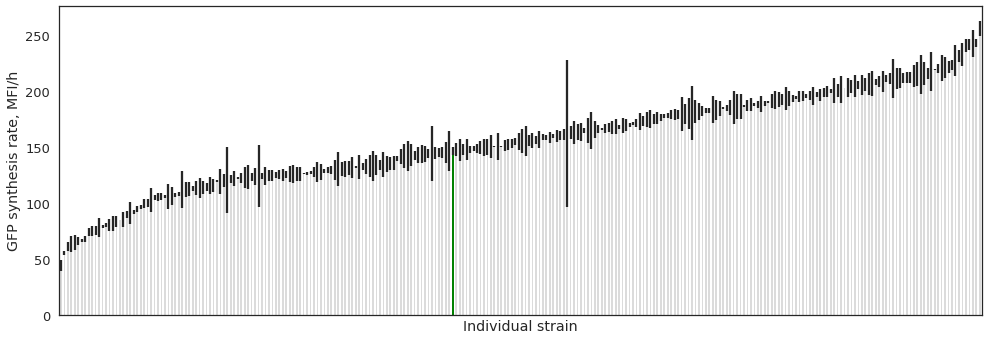

In [96]:
fig, axes = plt.subplots(figsize = (14, 5))
fig.set_tight_layout(True)

productivity_lib_ctr.plot(kind = 'bar', y='mean', yerr = 'sem', alpha = 0.3, width = 0.5, legend=False, ax=axes); #

# Highlight platform strains 
for bar in axes.patches:
    bar.set_facecolor('#888888')
highlight = 'SP507'
pos = productivity.index.get_loc(highlight)
axes.patches[pos].set_facecolor('green')
axes.patches[pos].set_alpha(1)

#fontsize = 24
axes.set_xlabel('Individual strain')
axes.set_ylabel('GFP synthesis rate, MFI/h');
axes.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    labelbottom=False) # labels along the bottom edge are off
fig.savefig("./figures/Figure 3F.pdf") #, bbox_inches='tight'

In [97]:
print('The average coefficient of variation for the mean values is: {}%'.format(round(productivity_lib_ctr['sem'].mean()/productivity_lib_ctr['mean'].mean() * 100,1)))

The average coefficient of variation for the mean values is: 4.3%


**For library and recommended strains**

In [99]:
print('The percent difference in productivity between max recommended and platform strain is: {}%'.format(round(max_rec / platform * 100)))

The percent difference in productivity between max recommended and platform strain is: 206.0%


In [100]:
print('The percent difference in productivity between max recommended and max library is: {}%'.format(round(max_rec/max_lib * 100)))

The percent difference in productivity between max recommended and max library is: 117.0%


# Modeling

## Reformat for ART

Filter library and control strains, combine the `Line Name` and `replicate_count` columns, and finally select  relevant columns  

In [101]:
strains_art_oneh = strains.copy().loc[np.logical_or(strains['origin'] == 'lib',
                                                   strains['origin'] == 'ctr')]

strains_art_oneh["Line Name"] = strains_art_oneh["Line Name"] + "-" + strains_art_oneh["replicate_count"]

strains_art_oneh = strains_art_oneh.loc[:,['Line Name','dgfp_dt','p1', 'p2', 'p3', 'p4', 'p5']]
strains_art_oneh.head()

,Line Name,dgfp_dt,p1,p2,p3,p4,p5
0,SP003-r1,99.225224,2.0,11.0,13.0,24.0,29.0
1,SP003-r2,107.346770,2.0,11.0,13.0,24.0,29.0
2,SP003-r3,109.504167,2.0,11.0,13.0,24.0,29.0
3,SP004-r1,169.829824,2.0,11.0,13.0,19.0,25.0
4,SP004-r2,155.425955,2.0,11.0,13.0,19.0,25.0


### One hot encode variables

In [102]:
strains_art_oneh = pd.get_dummies(data=strains_art_oneh, columns=['p1', 'p2', 'p3', 'p4','p5'])
strains_art_oneh.head()

,Line Name,dgfp_dt,p1_1.0,p1_2.0,p1_3.0,p1_4.0,p1_5.0,p1_6.0,p2_7.0,p2_8.0,...,p4_21.0,p4_22.0,p4_23.0,p4_24.0,p5_25.0,p5_26.0,p5_27.0,p5_28.0,p5_29.0,p5_30.0
0,SP003-r1,99.225224,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,SP003-r2,107.346770,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,SP003-r3,109.504167,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,SP004-r1,169.829824,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,SP004-r2,155.425955,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Store colnames as parameter setting for ART

In [103]:
colnames = strains_art_oneh.columns[2:].tolist()

Pivot dataframe and change column names

In [104]:
strains_art_oneh = strains_art_oneh.set_index('Line Name').stack().reset_index()
strains_art_oneh.columns = ['Line Name', 'Measurement Type', 'Value']
strains_art_oneh.head()

,Line Name,Measurement Type,Value
0,SP003-r1,dgfp_dt,99.225224
1,SP003-r1,p1_1.0,0.000000
2,SP003-r1,p1_2.0,1.000000
3,SP003-r1,p1_3.0,0.000000
4,SP003-r1,p1_4.0,0.000000


## JBEI ART

### Filtering of outliers

In [105]:
measurement = ['dgfp_dt']

In [106]:
noisy_line_name = utils.find_noisy_data(strains_art_oneh, measurement, percentile=99,plot_flag=False)

,Value,Measurement Type,Replicate Mean,Replicate Error
Line Name,,,,
SP224-r1,79.990664,dgfp_dt,123.932894,-43.942229
SP224-r3,174.085502,dgfp_dt,123.932894,50.152609
SP350-r1,278.266173,dgfp_dt,161.715406,116.550767
SP350-r3,51.049123,dgfp_dt,161.715406,-110.666283
SP354-r1,69.047804,dgfp_dt,120.296245,-51.248441
SP354-r3,171.159184,dgfp_dt,120.296245,50.862939
SP365-r2,227.141780,dgfp_dt,180.436352,46.705428
SP380-r1,193.137657,dgfp_dt,144.095323,49.042334


In [107]:
strains_art_oneh_filtered = utils.filter_noisy_data(strains_art_oneh, noisy_line_name, measurement, filter_all_replicates=True,plot_flag=False)

,Line Name,Measurement Type,Value
10447,SP224-r1,dgfp_dt,79.990664
10478,SP224-r2,dgfp_dt,117.722515
10509,SP224-r3,dgfp_dt,174.085502
16275,SP350-r1,dgfp_dt,278.266173
16306,SP350-r2,dgfp_dt,155.830922
16337,SP350-r3,dgfp_dt,51.049123
16368,SP354-r1,dgfp_dt,69.047804
16399,SP354-r2,dgfp_dt,120.681747
16430,SP354-r3,dgfp_dt,171.159184
17112,SP365-r1,dgfp_dt,147.364666


In [108]:
errors = utils.add_replicate_mean_and_error(strains_art_oneh, ['dgfp_dt'])['Replicate Error']
limit = round(np.percentile(abs(errors), 99),2)
print("The value that delimites the one percent most extreme errors is: {}".format(limit))

The value that delimites the one percent most extreme errors is: 35.88


In [143]:
errors.abs().mean()*2.5

20.956988877637936

In [144]:
# sns.set_context("talk")
# sns.set_style("white")

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


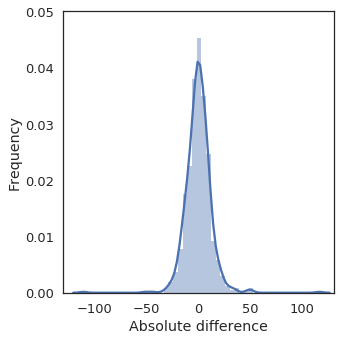

In [110]:
fig, ax = plt.subplots(figsize=(5, 5))
fig.set_tight_layout(True)
sns.distplot(errors, ax=ax);
ax.set_ylim(0, 0.05)
ax.set_xlim(-130, 130)
ax.set_ylabel('Frequency')
ax.set_xlabel('Absolute difference')
fig.savefig('./figures/Figure 4B.pdf')

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


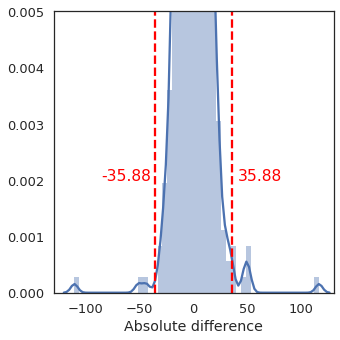

In [111]:
fig, ax = plt.subplots(figsize=(5, 5))
fig.set_tight_layout(True)
sns.distplot(errors, ax=ax)
ax.set_ylim(0, 0.005)
ax.set_xlim(-130, 130)
ax.axvline(x=limit, ymin=0, color='r', ls='--')
ax.axvline(x=-limit, ymin=0, color='r', ls='--')
ax.annotate(str(round(-limit, 2)), xy=(-limit-50, 0), xytext=(-limit-50, 0.002), color='r')
ax.annotate(str(round(limit, 2)), xy=(limit+5, 0), xytext=(limit+5, 0.002), color='r')
ax.set_xlabel('Absolute difference')
fig.savefig('./figures/Figure 4C.pdf')

In [147]:
### Running ART

Assign ART parameters:

In [119]:
art_params = {}
art_params['response_var'] = measurement
art_params['input_var'] = colnames
art_params['seed'] = 1234  # default: None
art_params['num_recommendations'] = 30   
art_params['cross_val'] = True
art_params['recommend'] = False
art_params['output_directory'] = 'results_onehot/'


Run ART with seed (takes around 15h) or load previously run model.

In [113]:
run_art = False

In [120]:
%%time
if run_art:
    art = RecommendationEngine(strains_art_oneh_filtered, **art_params)
else:
    with open('results_onehot/art.pkl', 'rb') as output:
        art = pickle.load(output)

CPU times: user 68 ms, sys: 20 ms, total: 88 ms
Wall time: 88.2 ms


Evaluate individual ensemble models

In [152]:
art.evaluate_models_cv()

,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,28.138447,20.361717,23.362420,1337.574858,0.280271
Random Forest Regressor,22.179447,16.572849,20.586204,915.719671,0.507265
TPOT Regressor,22.129173,16.830512,18.869021,845.740245,0.544920
Support Vector Regressor,31.538757,25.082998,23.121450,1529.294651,0.177109
Kernel Ridge Regressor,67.255258,40.803989,48.364739,6862.417693,-2.692567
K-NN Regressor,30.869251,22.341597,24.013975,1529.581659,0.176954
Gaussian Process Regressor,24.741041,18.732631,20.313311,1024.749716,0.448597
Gradient Boosting Regressor,23.318813,17.875105,20.019813,944.559977,0.491746
Ensemble Model,21.391234,16.266258,18.653812,805.549592,0.566546


The crossvalidated MAE and R2 values for the ensemble model is 21.4 and 0.57, respectively

Crossvalidated ensemble prediction compared to observations of mean productivity of library and control strains 

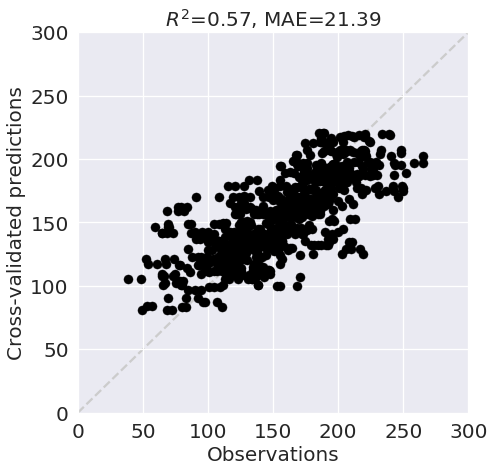

In [153]:
plot.predictions_vs_observations(art, cv_flag=True, errorbars_flag=False, xlim=[[0, 300]], ylim=[[0, 300]], log=False)

Ensemble prediction compared to observations of mean productivity of library and control strains 

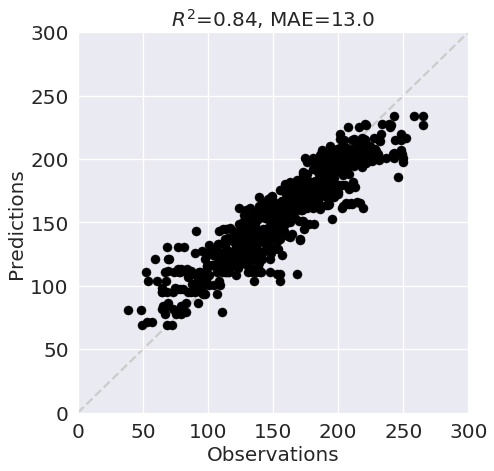

In [123]:
plot.predictions_vs_observations(art, cv_flag=False, errorbars_flag=False, xlim=[[0, 300]], ylim=[[0, 300]], log=False)

### Learning curves

10 cross-validation runs were performed in parallel running the script `learning_curves_per_set_size.py` with arguments `run_number` and `set_index` (between 0 and 14 for a total of 15 cases). The results were stored in

In [182]:
output_directory = './results_onehot/learning_curves'

Importing results

In [183]:
num_runs = 10
metrics_all = {}
for run in range(num_runs):
    filename = f'{output_directory}/metrics_train_test_{run+1}.pkl'
    with open(filename, 'rb') as f:
        metrics_all[run] = pickle.load(f)  

Define plot function

In [185]:
def plot_learning_curves(metrics_all, metric_str, xlim=None, ylim=None):
    
    set_sizes = np.array([10,  28,  46,  64,  82, 100, 118, 136, 154, 172, 190, 208, 226, 244, 261])
    num_cases = len(set_sizes)
    
    metric = np.array([metrics_all[run]['Train'][metric_str][0] 
                       for run in range(num_runs)]).reshape(-1,num_cases)  # reshape (num_runs, num_folds, num_cases) to (num_runs*num_folds, num_cases) 
    metric_train_mean = np.mean(metric,0)
    metric_train_std = np.std(metric,0)
    
    metric = np.array([metrics_all[run]['Test'][metric_str][0] 
                       for run in range(num_runs)]).reshape(-1,num_cases)
    metric_test_mean = np.mean(metric,0)
    metric_test_std = np.std(metric,0)
    
    conf_int_factor = 1.96
    
    fig, ax = plt.subplots(figsize=(5, 5))
    fig.set_tight_layout(True)
    plt.plot(set_sizes, metric_test_mean, '.-', color='r',label='Test')
    plt.fill_between(set_sizes, metric_test_mean-conf_int_factor*metric_test_std, 
                     metric_test_mean+conf_int_factor*metric_test_std, alpha=0.1, facecolor='r')
    plt.plot(set_sizes, metric_train_mean, '.-', color='b',label='Train')
    plt.fill_between(set_sizes, metric_train_mean-conf_int_factor*metric_train_std, 
                     metric_train_mean+conf_int_factor*metric_train_std, alpha=0.1, facecolor='b')
    
    plt.legend(loc='best', shadow=True)

    plt.xlabel("Number of genotypes in the data set")
    plt.ylabel(metric_str + ', MFI/h')
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    
    fig.savefig(output_directory + '/learning_curves_' + metric_str + '.png')
    if metric_str == 'MAE':
        fig.savefig('./figures/Figure 5A.pdf')

Plot

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


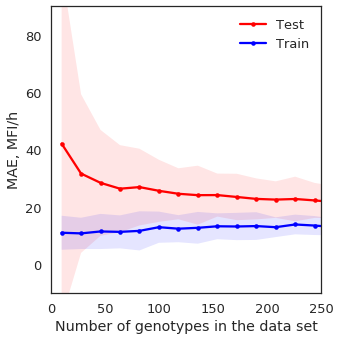

In [186]:
sns.set_context("talk")
sns.set_style("white")
plot_learning_curves(metrics_all, 'MAE', [0,250],[-10,90])

### Add predictions to main datastructure

In [124]:
cv_prediction      = np.array(art.model_df_cv[0]['Predictions']['Ensemble Model'])
predicted_mean, predicted_std = art.post_pred_stats(art.load_input_data(scale=False))
jbei_library_pred_df    = pd.DataFrame({'Line Name' : strains_art_oneh_filtered['Line Name'].unique(),'prediction_JBEI' : predicted_mean.squeeze(), 'cv_prediction_JBEI' : cv_prediction})
jbei_library_pred_df['Line Name'], jbei_library_pred_df['replicate_count'] = jbei_library_pred_df['Line Name'].str.split('-', 1).str
jbei_library_pred_df.head()

,Line Name,prediction_JBEI,cv_prediction_JBEI,replicate_count
0,SP003,115.817938,123.060070,r1
1,SP003,115.817938,123.060070,r2
2,SP003,115.817938,123.060070,r3
3,SP004,151.010237,152.452658,r1
4,SP004,151.010237,152.452658,r2


In [125]:
strains = pd.merge(strains, jbei_library_pred_df,  how='left', left_on=['Line Name', 'replicate_count'], right_on = ['Line Name', 'replicate_count'])
strains.head()

,Line Name,replicate_count,Line Description,origin,time_series,p1,p2,p3,p4,p5,...,gfp_t_r_od_max,gfp_p_od_t_od_t1,gfp_p_od_t_od_t2,gfp_p_od_t_r_od_max,delta_t,delta_od,delta_gfp,dgfp_dt,prediction_JBEI,cv_prediction_JBEI
0,SP003,r1,02_11_13_24_29,lib,time gfp od od_minus_bg gfp...,2.0,11.0,13.0,24.0,29.0,...,1311.71591435308,4699.659395980494,4763.715841111394,1429.734827125743,3.72,0.074807,369.117832,99.225224,115.817938,123.060070
1,SP003,r2,02_11_13_24_29,lib,time gfp od od_minus_bg gfp...,2.0,11.0,13.0,24.0,29.0,...,1405.4869644164728,5034.872338696571,4816.526405891368,3016.7901853077365,3.16,0.075211,339.215794,107.346770,115.817938,123.060070
2,SP003,r3,02_11_13_24_29,lib,time gfp od od_minus_bg gf...,2.0,11.0,13.0,24.0,29.0,...,1575.123819879755,7741.328071276553,5929.480569764345,2466.220469271193,2.85,0.075353,312.086877,109.504167,115.817938,123.060070
3,SP004,r1,02_11_13_19_25,lib,time gfp od od_minus_bg gfp...,2.0,11.0,13.0,19.0,25.0,...,1710.197181761548,5225.70568448656,5313.995119067842,2184.660960653404,2.42,0.074935,410.988174,169.829824,151.010237,152.452658
4,SP004,r2,02_11_13_19_25,lib,time gfp od od_minus_bg gfp...,2.0,11.0,13.0,19.0,25.0,...,1668.7570441848184,5061.435288793469,4936.929300380902,2694.832956446529,2.28,0.075204,354.371179,155.425955,151.010237,152.452658


### Recommend new designs

Create the set of all possible designs:

In [126]:
num_of_promoters = 6
num_of_genes = 5
num_of_designs = num_of_promoters**num_of_genes
num_of_promoters_onehot = art.num_input_var
designs = np.zeros((num_of_designs, num_of_promoters_onehot))
num_of_designs

7776

In [127]:
i = 0
promoters = np.eye(6)

for p1 in promoters:
    for p2 in promoters:
        for p3 in promoters:
            for p4 in promoters:
                for p5 in promoters:
                    designs[i,:] = np.hstack((p1,p2,p3,p4,p5)).astype(int)
                    i+=1
        

Calculate mean predicted production and standard deviation for all possible designs.

In [129]:
pp_mean, pp_std = art.post_pred_stats(designs)


The relative engineering accuracy is set to one percent to make sure recommendations are different from the input data.

In [130]:
art.rel_eng_accuracy = 0.01

#### Exploitative approach

Objective function is defined as the mean predicted production (the parameter for exploration is set to $\alpha=0$).

In [179]:
obj_func = pp_mean 
data = np.hstack((designs, obj_func, obj_func))

In [180]:
art.recommend(data=data)
ind_max = np.argmax(art.recommendations.values[:,-1])
mean, std = art.post_pred_stats(art.recommendations.values[ind_max,:-1])
print(f'Mean and standard deviation of the recommendation with the highest predicted production are: {mean[0][0]:.2f}, {std[0][0]:.2f}')

Mean and standard deviation of the recommendation with the highest predicted production are: 242.37, 29.23


Convert one-hot formatted variables back into categorical gene positions

In [181]:
df_rec_categ_exploit = pd.DataFrame(index=art.recommendations.index, columns=['p1','p2','p3','p4','p5',measurement[0]])
for i in range(art.num_recommendations):
    rec = art.recommendations.iloc[i][art.recommendations.values[i,:] > 0]
    df_rec_categ_exploit.iloc[i]['p1':'p5'] = [int(float(p.split('_')[1])) for p in rec.index[:-1]]
    df_rec_categ_exploit.iloc[i][measurement] = rec[measurement]
df_rec_categ_exploit.head()

,p1,p2,p3,p4,p5,dgfp_dt
0,3,8,16,22,28,242.369
1,3,8,16,19,28,240.272
2,3,8,16,22,29,240.24
3,3,8,16,19,29,238.095
4,3,8,16,19,26,237.456


In [182]:
df_rec_categ_exploit.nunique()

p1          4
p2          3
p3          2
p4          6
p5          5
dgfp_dt    30
dtype: int64

#### Explorative approach

Objective function is defined as the variance of the predicted production (the parameter for exploration is set to $\alpha=1$).

In [221]:
obj_func = pp_std 
data = np.hstack((designs, obj_func, obj_func))


In [222]:
art.recommend(data=data)
ind_max = np.argmax(art.recommendations.values[:,-1])
mean, std = art.post_pred_stats(art.recommendations.values[ind_max,:-1])
print(f'Mean and standard deviation of the recommendation with the highest predicted production are: {mean[0][0]:.2f}, {std[0][0]:.2f}')

Mean and standard deviation of the recommendation with the highest predicted production are: 228.82, 29.26


Convert one-hot formatted variables back into categorical gene positions

In [223]:
df_rec_categ_explor = pd.DataFrame(index=art.recommendations.index, columns=['p1','p2','p3','p4','p5',measurement[0]])
for i in range(art.num_recommendations):
    rec = art.recommendations.iloc[i][art.recommendations.values[i,:] > 0]
    df_rec_categ_explor.iloc[i]['p1':'p5'] = [int(float(p.split('_')[1])) for p in rec.index[:-1]]
    df_rec_categ_explor.iloc[i][measurement] = rec[measurement]
df_rec_categ_explor.head()

,p1,p2,p3,p4,p5,dgfp_dt
0,2,11,14,20,29,189.334
1,3,9,16,19,28,202.864
2,2,11,14,23,29,188.761
3,2,12,14,20,30,178.077
4,6,12,15,20,29,155.823


In [224]:
df_rec_categ_explor.nunique()

p1          5
p2          5
p3          5
p4          4
p5          4
dgfp_dt    30
dtype: int64

## Teselagen

### Learning curves

Importing results

In [193]:
metrics_all = pd.read_csv('teselagen_learning_curve_data.csv')
metrics_all.tail()

,exp,test_mae_avg,test_mae_std,test_r2_avg,test_r2_std,train_mae_avg,train_mae_std,train_r2_avg,train_r2_std
9,172,22.973734,4.397415,0.394311,0.269267,10.022031,0.958162,0.905999,0.019202
10,190,23.131315,4.495760,0.434195,0.230873,10.712708,0.743214,0.894330,0.017340
11,208,22.742736,4.259884,0.416309,0.289164,10.097509,0.438831,0.905050,0.008457
12,227,22.738374,4.264699,0.449007,0.188481,10.614835,0.571654,0.896277,0.011916
13,246,22.372488,3.707472,0.440812,0.162934,10.615515,0.415947,0.896794,0.007010


Define plot function

In [194]:
def plot_learning_curves_tes(metric_all, metric_str, xlim=None, ylim=None):
    
    col_str_test_avg  = 'test_' + metric_str.lower()+'_avg'
    col_str_test_std  = 'test_' + metric_str.lower()+'_std'
    col_str_train_avg = 'train_' + metric_str.lower()+'_avg'
    col_str_train_std = 'train_' + metric_str.lower()+'_std'
    
    set_sizes = metric_all.exp.values
    metric_train_mean = metrics_all[col_str_train_avg].values
    metric_train_std  = metrics_all[col_str_train_std].values
    metric_test_mean  = metrics_all[col_str_test_avg].values
    metric_test_std   = metrics_all[col_str_test_std].values
    
    conf_int_factor = 1.96
    
    fig, ax = plt.subplots(figsize=(5, 5))
    fig.set_tight_layout(True)
    plt.plot(set_sizes, metric_test_mean, '.-', color='r',label='Test')
    plt.fill_between(set_sizes, metric_test_mean-conf_int_factor*metric_test_std, 
                     metric_test_mean+conf_int_factor*metric_test_std, alpha=0.1, facecolor='r')
    plt.plot(set_sizes, metric_train_mean, '.-', color='b',label='Train')
    plt.fill_between(set_sizes, metric_train_mean-conf_int_factor*metric_train_std, 
                     metric_train_mean+conf_int_factor*metric_train_std, alpha=0.1, facecolor='b')
    
    plt.legend(loc='best', shadow=True)
    
    #plt.title('Learning curves', fontsize=fontsize+2)
    plt.xlabel("Number of genotypes in the data set")
    plt.ylabel(metric_str + ', MFI/h')
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    
    fig.savefig(output_directory + '/learning_curves_' + metric_str + '_tes' + '.png')
    if metric_str == 'MAE':
        fig.savefig('./figures/Figure 5B.pdf')

Plot

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


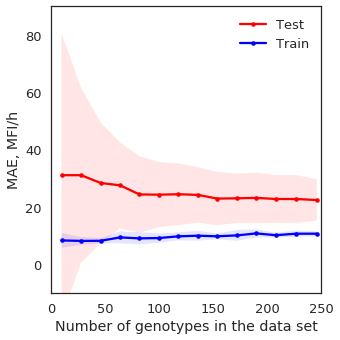

In [195]:
sns.set_context("talk")
sns.set_style("white")
plot_learning_curves_tes(metrics_all,'MAE', [0,250], [-10,90])

### Add predictions to main datastructure

In [139]:
tes_library_pred_df = pd.read_csv('cv_predictions_tes.csv', usecols = ['Line Name', 'cv_prediction_Tes'])
tes_library_pred_df['Line Name'], tes_library_pred_df['replicate_count'] = tes_library_pred_df['Line Name'].str.split('-', 1).str
tes_library_pred_df['prediction_Tes'] = np.nan
tes_library_pred_df.head()

,Line Name,cv_prediction_Tes,replicate_count,prediction_Tes
0,SP003,131.711594,r1,NaN
1,SP003,131.711594,r2,NaN
2,SP003,131.711594,r3,NaN
3,SP004,164.302960,r1,NaN
4,SP004,164.302960,r2,NaN


Join library_pred_df to strains

In [140]:
strains = pd.merge(strains, tes_library_pred_df,  how='left', left_on=['Line Name', 'replicate_count'], right_on = ['Line Name', 'replicate_count'])

## Joining recommendation predictions data to main dataframe

Import recommendations metadata incl. predicted values

In [142]:
rec_lookup = pd.read_csv('./rec_lookup.csv', usecols=['Line Name', 'prediction_JBEI', 'cv_prediction_JBEI','prediction_Tes','cv_prediction_Tes','From'])
rec_lookup.head()

,Line Name,prediction_JBEI,cv_prediction_JBEI,prediction_Tes,cv_prediction_Tes,From
0,SP577,NaN,NaN,206.6,206.6,Tes
1,SP580,NaN,NaN,228.3,228.3,Tes
2,SP581,NaN,NaN,198.8,198.8,Tes
3,SP582,NaN,NaN,199.3,199.3,Tes
4,SP586,235.2,235.2,NaN,NaN,JBEI


Combine with main dataframe

In [143]:
cols = strains.columns
strains = strains.set_index('Line Name').combine_first(rec_lookup.set_index('Line Name')).reset_index()
strains = strains[cols]

## Plot cross validated predictions compared with mean observations

Create color scheme according to origin in main dataframe

In [145]:
strains['coloring'] = strains['origin']
di = {"lib": "lightgrey","ctr": "lightgrey", "JBEI": "blue", "Tes": "blue", "both":'orange'}
strains = strains.replace({"coloring": di})

Include platform strain

In [146]:
strains.loc[strains['Line Name'] == "SP507", ['coloring']] = 'green'

In [148]:
strains.head()

,Line Name,replicate_count,Line Description,origin,time_series,p1,p2,p3,p4,p5,...,gfp_p_od_t_r_od_max,delta_t,delta_od,delta_gfp,dgfp_dt,prediction_JBEI,cv_prediction_JBEI,cv_prediction_Tes,prediction_Tes,coloring
0,SP003,r1,02_11_13_24_29,lib,time gfp od od_minus_bg gfp...,2.0,11.0,13.0,24.0,29.0,...,1429.734827125743,3.72,0.074807,369.117832,99.225224,115.817938,123.060070,131.711594,NaN,lightgrey
1,SP003,r2,02_11_13_24_29,lib,time gfp od od_minus_bg gfp...,2.0,11.0,13.0,24.0,29.0,...,3016.7901853077365,3.16,0.075211,339.215794,107.346770,115.817938,123.060070,131.711594,NaN,lightgrey
2,SP003,r3,02_11_13_24_29,lib,time gfp od od_minus_bg gf...,2.0,11.0,13.0,24.0,29.0,...,2466.220469271193,2.85,0.075353,312.086877,109.504167,115.817938,123.060070,131.711594,NaN,lightgrey
3,SP004,r1,02_11_13_19_25,lib,time gfp od od_minus_bg gfp...,2.0,11.0,13.0,19.0,25.0,...,2184.660960653404,2.42,0.074935,410.988174,169.829824,151.010237,152.452658,164.302960,NaN,lightgrey
4,SP004,r2,02_11_13_19_25,lib,time gfp od od_minus_bg gfp...,2.0,11.0,13.0,19.0,25.0,...,2694.832956446529,2.28,0.075204,354.371179,155.425955,151.010237,152.452658,164.302960,NaN,lightgrey


Calculate mean productivity

In [149]:
strains_agg = (strains.groupby('Line Name',as_index=False)
                       .agg({'dgfp_dt':'mean', 'Line Description':'first', 'cv_prediction_JBEI':'mean', 'cv_prediction_Tes':'mean', 'coloring':'first'}))
strains_agg.head()

,Line Name,dgfp_dt,Line Description,cv_prediction_JBEI,cv_prediction_Tes,coloring
0,SP003,105.358720,02_11_13_24_29,123.060070,131.711594,lightgrey
1,SP004,159.715748,02_11_13_19_25,152.452658,164.302960,lightgrey
2,SP008,112.879576,02_11_15_22_25,119.861007,126.778616,lightgrey
3,SP011,160.998056,01_09_13_22_25,160.033471,174.021430,lightgrey
4,SP014,198.804384,05_09_13_22_25,181.827415,197.877406,lightgrey


Plot cross validated predictions compared to mean observations

In [200]:
sns.set_context("talk")
sns.set_style("white")

For JBEI

In [216]:
mask_all_data = ~np.isnan(strains_agg.dgfp_dt) & ~np.isnan(strains_agg.cv_prediction_JBEI)
mask_train_data = ~np.isnan(strains_agg.dgfp_dt) & ~np.isnan(strains_agg.cv_prediction_JBEI) & (strains_agg['coloring']=='lightgrey')


In [197]:
len(strains_agg.dgfp_dt[mask_all_data]),len(strains_agg.dgfp_dt[mask_train_data])

(285, 260)

R^2 = 0.6032 for train data only


/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


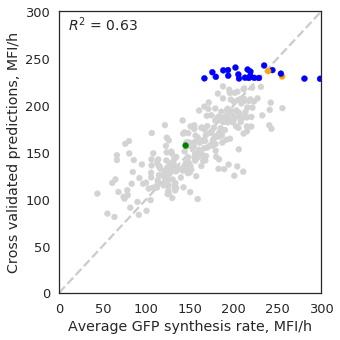

In [217]:
fig, ax = plt.subplots(figsize=(5, 5))
fig.set_tight_layout(True)
strains_agg.plot(kind = 'scatter', x='dgfp_dt', y = 'cv_prediction_JBEI', color=strains_agg.coloring, s=35, ax=ax)

r_value = r2_score(strains_agg.dgfp_dt[mask_all_data], strains_agg.cv_prediction_JBEI[mask_all_data])
ax.text(10, 280,'$R^2$ = {}'.format(round(r_value,2)),fontsize=14)

r_value = r2_score(strains_agg.dgfp_dt[mask_train_data], strains_agg.cv_prediction_JBEI[mask_train_data])
print('R^2 = {} for train data only'.format(round(r_value,4)))

ax.set_xlabel('Average GFP synthesis rate, MFI/h')
ax.set_ylabel('Cross validated predictions, MFI/h')

ax.set_xlim(0, 300)
ax.set_ylim(0, 300)

# Plot Diagonal Dashed Line
lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()])]  # max of both axes
ax.plot(lims, lims, ls='--', color='.8', zorder=0)
fig.savefig("./figures/Figure 5E.pdf")

For Teselagen

In [218]:
mask_all_data = ~np.isnan(strains_agg.dgfp_dt) & ~np.isnan(strains_agg.cv_prediction_Tes)
mask_train_data = ~np.isnan(strains_agg.dgfp_dt) & ~np.isnan(strains_agg.cv_prediction_Tes) & (strains_agg['coloring']=='lightgrey')


R^2 = 0.4375 for train data only


/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


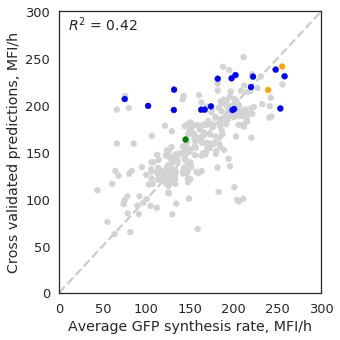

In [219]:
fig, ax = plt.subplots(figsize=(5, 5))
fig.set_tight_layout(True)
strains_agg.plot(kind = 'scatter', x='dgfp_dt', y = 'cv_prediction_Tes', color=strains_agg.coloring, s=35, ax=ax)

ax.set_xlabel('Average GFP synthesis rate, MFI/h')
ax.set_ylabel('Cross validated predictions, MFI/h')

r_value = r2_score(strains_agg.dgfp_dt[mask_all_data], strains_agg.cv_prediction_Tes[mask_all_data])
ax.text(10, 280,'$R^2$ = {}'.format(round(r_value,2)),fontsize=14)

r_value = r2_score(strains_agg.dgfp_dt[mask_train_data], strains_agg.cv_prediction_Tes[mask_train_data])
print('R^2 = {} for train data only'.format(round(r_value,4)))

ax.set_xlim(0, 300)
ax.set_ylim(0, 300)

# Plot Diagonal Dashed Line
lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()])]  # max of both axes
ax.plot(lims, lims, ls='--', color='.8', zorder=0)
fig.savefig("./figures/Figure 5F.pdf")

# Figure 3D

In [138]:
val = pd.read_csv('biosensor_val.csv')
val

,bios_mean,bios_se,hplc_mean,hplc_se
0,3280.596226,206.019624,3.485611,0.079723
1,5123.172153,275.288558,5.334417,0.144421
2,6985.272887,200.730468,4.863333,0.289681
3,7425.070589,376.875999,5.856779,0.104144
4,3876.809365,267.557269,4.274195,0.254407
5,3588.420317,100.931333,3.656587,0.181026


In [139]:
gradient, intercept, r_value, p_value, std_err = stats.linregress(val.bios_mean,val.hplc_mean)
#print("Gradient and intercept", round(gradient,3), round(intercept,3))
#print("R-squared", round(r_value**2,3))
#print("p-value", round(p_value,3))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


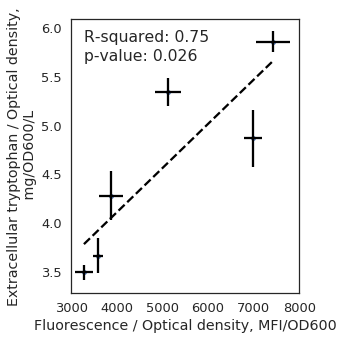

In [140]:
fig, ax = plt.subplots(figsize=(5, 5))
fig.set_tight_layout(True)
val.plot(kind='scatter',x='bios_mean',y='hplc_mean', ax=ax);
ax.errorbar('bios_mean', 'hplc_mean',xerr='bios_se' ,yerr='hplc_se', ls='none', ecolor='black', data=val);

xmin, xmax = val.bios_mean.min(),val.bios_mean.max()
ymin, ymax = val.hplc_mean.min(),val.hplc_mean.max()

ax.text(xmin, ymax, s="R-squared: " + str(round(r_value**2,2)))
ax.text(xmin, ymax-ymax/30, s="p-value: " + str(round(p_value,3)))

x_val = np.linspace(xmin,xmax,100)
ax.plot(x_val, x_val*gradient + intercept, ls = '--', color = 'k');
ax.set_xlim(3000, 8000)
#ax.set_xticks(ax.get_xticks()[::2])

ax.set_xlabel('Fluorescence / Optical density, MFI/OD600')
ax.set_ylabel('Extracellular tryptophan / Optical density,\n mg/OD600/L')

fig.savefig("./figures/Figure 3D.pdf")

# Figure 3E

Unnest the time series data that is nested within the main dataframe `strains`

In [141]:
lst = []
for i in range(len(strains)):
    df = strains.iloc[i]['time_series']
    df['Line Name'] = strains.iloc[i]['Line Name']
    df['replicate_count'] = strains.iloc[i]['replicate_count']
    df['origin'] = strains.iloc[i]['origin']
    cols = df.columns.tolist()
    cols = cols[-3:] + cols[:-3]
    df = df[cols]
    lst.append(df)
strains_unnested_second = pd.concat(lst)

Extract the library and control strains from `strains_unnested_second`

In [142]:
strains_unnested_second_lib = strains_unnested_second[np.logical_or(strains_unnested_second['origin']=='lib',strains_unnested_second['origin']=='ctr')]                               

Calculate gfp per od and add it to `strains_unnested_second`

In [143]:
strains_unnested_second_lib['gfp_p_od'] = strains_unnested_second_lib.apply(lambda row: row['gfp_minus_bg']/row['od_minus_bg'], axis=1).copy()

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Fluorescence divided by OD related to OD for library and control strains

/usr/local/share/jupyteruser/.pyenv/versions/ART_3.6/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


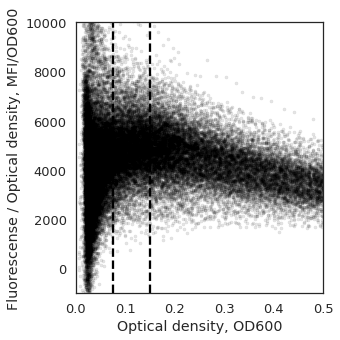

In [144]:
fig, ax = plt.subplots(figsize=(5, 5))
fig.set_tight_layout(True)

strains_unnested_second_lib.plot(kind = 'scatter', x='od_minus_bg', y = 'gfp_p_od', alpha = 0.1, color = 'k', s=10, ax=ax)
ax.axvline(x=0.075, ls = '--', color = 'k')
ax.axvline(x=0.15, ls = '--', color = 'k')

ax.set_xlim(0, 0.5)
ax.set_ylim(-1000, 10000)

ax.set_xlabel('Optical density, OD600')
ax.set_ylabel('Fluorescense / Optical density, MFI/OD600')

fig.savefig("./figures/Figure 3E.pdf")